In [1]:
import os
import sys
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb  
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import timm  
import math 
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns

logging.basicConfig(level=logging.INFO)

# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
GRADIENT_ACCUM_STEPS = 4        # Accumulate gradients over mini-batches
NUM_FRAMES = 50
# Progressive resolution schedule: (resolution, epochs)
PROG_SCHEDULE = [(112, 6), (168, 5), (224, 10), (300, 9)]
FOCAL_ALPHA = 0.25
FOCAL_GAMMA = 2.0

# ------------------------------
# Environment & Paths
# ------------------------------
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Image Transformations
# ------------------------------
def get_transform(resolution):
    return transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


Models directory exists: True
Checkpoint path writable: True
Using device: cuda


In [2]:
# ------------------------------
# Utility Functions
# ------------------------------
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    return base.replace("110001", "202614", 1) if base.startswith("110001") else base

def select_impactful_frames(video_folder: Path, num_frames=50):
    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    total = len(frame_files)
    if total == 0:
        return []
    if total <= num_frames:
        return frame_files
    indices = np.linspace(0, total - 1, num_frames, dtype=int)
    return [frame_files[i] for i in indices]

# ------------------------------
# Precomputation & Caching Functions
# ------------------------------
def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=50, resolution=224):
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = csv_file.stem.replace("Labels", "").strip()
    valid_indices = []
    precomputed = []
    skipped = 0
    for idx, row in tqdm(data.iterrows(), total=len(data),
                         desc=f"Precomputing frames for {csv_file.stem} at {resolution}x{resolution}"):
        clip_id = get_csv_clip_id(row["ClipID"].split('.')[0])
        video_folder = video_root / split / clip_id
        if video_folder.exists():
            frames = select_impactful_frames(video_folder, num_frames)
            if len(frames) >= num_frames:
                precomputed.append(frames[:num_frames])
                valid_indices.append(idx)
            else:
                skipped += 1
        else:
            skipped += 1
    print(f"Precomputation: Skipped {skipped} videos out of {len(data)}.")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    cache_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Precomputed results saved to {cache_file}")
    return cache_data

def convert_pkl_to_lmdb(csv_file: Path, num_frames=50, resolution=224,
                          transform=None, lmdb_map_size=1 * 1024**3):
    if transform is None:
        transform = get_transform(resolution)
    pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    lmdb_path = CACHE_DIR / f"lmdb_{csv_file.stem}_frame_{num_frames}_{resolution}"
    # If LMDB already exists, return it.
    if (lmdb_path / "data.mdb").exists():
        print(f"LMDB database already exists at {lmdb_path}")
        return lmdb_path

    env = lmdb.open(str(lmdb_path), map_size=lmdb_map_size)
    if not pkl_file.exists():
        precompute_best_frames(csv_file, FRAMES_DIR, num_frames=num_frames, resolution=resolution)
    with open(pkl_file, "rb") as f:
        cache = pickle.load(f)
    valid_indices = cache["valid_indices"]
    file_paths_list = cache["precomputed_frames"]

    # Use EfficientNetV2-L (tf variant) from timm with frozen backbone
    backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
    backbone.reset_classifier(0)
    backbone.eval()
    backbone.to(device)
    for param in backbone.parameters():
        param.requires_grad = False

    print(f"Converting frame paths to LMDB features for {csv_file.stem} at {resolution}x{resolution} ...")
    with env.begin(write=True) as txn:
        for idx, paths in tqdm(enumerate(file_paths_list), total=len(file_paths_list)):
            video_features = []
            for fp in paths:
                try:
                    img = Image.open(fp).convert("RGB")
                except Exception:
                    img = Image.new('RGB', (resolution, resolution))
                tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                    feat = backbone(tensor)
                    feat = feat.squeeze(0).cpu().half().detach()  # ensure detached and on CPU
                # Convert to NumPy array to avoid pickling issues with torch tensors
                video_features.append(feat.numpy())
            if video_features:
                video_features_np = np.stack(video_features)  # shape: (num_frames, feature_dim)
                key = f"video_{valid_indices[idx]}".encode("utf-8")
                txn.put(key, pickle.dumps(video_features_np))
    env.close()
    print(f"LMDB database created at {lmdb_path}")
    return lmdb_path

# ------------------------------
# LMDB Dataset Classes
# ------------------------------
# ------------------------------
# LMDB Dataset Classes
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    def __init__(self, csv_file, lmdb_path, num_frames=50, resolution=224):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        self.resolution = resolution
        
        # Handle different path formats properly
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
        
        try:
            with open(pkl_file, "rb") as f:
                cache = pickle.load(f)
                self.valid_indices = cache["valid_indices"]
                self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        except Exception as e:
            print(f"Error loading cache file {pkl_file}: {e}")
            raise
            
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path) if isinstance(lmdb_path, Path) else lmdb_path
        self.env = None

    def _init_env(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)
        return self.env

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        env = self._init_env()
        original_idx = self.valid_indices[idx]
        key = f"video_{original_idx}".encode("utf-8")
        with env.begin(write=False) as txn:
            data_bytes = txn.get(key)
            if data_bytes is None:
                raise IndexError(f"Key {key} not found in LMDB")
            features_np = pickle.loads(data_bytes)
            # FIX: Convert to float32 here (critical fix)
            features = torch.from_numpy(features_np).float()  # Convert to float32 explicitly
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return features, torch.tensor(labels.values, dtype=torch.long)

class VideoDatasetRaw(torch.utils.data.Dataset):
    def __init__(self, csv_file, video_root, num_frames=50, transform=None):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_raw.pkl"
        if not pkl_file.exists():
            cache = precompute_best_frames(csv_file, video_root, num_frames=num_frames)
            with open(pkl_file, "wb") as f:
                pickle.dump(cache, f)
        else:
            with open(pkl_file, "rb") as f:
                cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.file_paths = cache["precomputed_frames"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paths = self.file_paths[idx]
        frames = []
        for fp in paths:
            try:
                img = Image.open(fp).convert("RGB")
            except Exception:
                img = Image.new('RGB', (self.transform.transforms[0].size, self.transform.transforms[0].size))
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        video_tensor = torch.stack(frames)  # (T, C, H, W)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return video_tensor, torch.tensor(labels.values, dtype=torch.long)

# -----------------------------
# Checkpoint Handling Functions
# -----------------------------
def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    """Save checkpoint with architecture information to prevent mismatch errors"""
    # Extract model architecture parameters
    lstm_hidden = model.lstm_hidden
    lstm_layers = model.lstm_layers
    dropout_rate = model.dropout_rate
    
    # Create architecture-specific path to prevent mismatches
    arch_path = checkpoint_path.parent / f"{checkpoint_path.stem}_h{lstm_hidden}_l{lstm_layers}_d{int(dropout_rate*100)}.pth"
    
    # Save comprehensive state
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "best_val_loss": best_val_loss,
        "architecture": {
            "lstm_hidden": lstm_hidden,
            "lstm_layers": lstm_layers,
            "dropout_rate": dropout_rate
        }
    }
    
    # Only include optimizer state if optimizer is not None
    if optimizer is not None:
        state["optimizer_state_dict"] = optimizer.state_dict()
    
    # Use safe saving technique (prevent corruption)
    temp_path = arch_path.with_suffix(".tmp")
    torch.save(state, temp_path)
    if arch_path.exists():
        arch_path.unlink()
    temp_path.rename(arch_path)
    print(f"Checkpoint saved to {arch_path}")
    return arch_path

### 
# Load checkpoint with architecture verification
###

def load_checkpoint(model, optimizer, checkpoint_path):
    """Load checkpoint with architecture verification"""
    if not checkpoint_path.exists():
        print(f"No checkpoint found at {checkpoint_path}")
        return False
    
    try:
        state = torch.load(checkpoint_path, map_location=device)
        
        # Architecture compatibility check
        if "architecture" in state:
            arch = state["architecture"]
            
            # Verify architecture compatibility
            if (arch["lstm_hidden"] != model.lstm_hidden or 
                arch["lstm_layers"] != model.lstm_layers or
                abs(arch["dropout_rate"] - model.dropout_rate) > 0.01):  # Small tolerance for float differences
                print(f"Architecture mismatch in checkpoint: {checkpoint_path}")
                print(f"Checkpoint: hidden={arch['lstm_hidden']}, layers={arch['lstm_layers']}, dropout={arch['dropout_rate']}")
                print(f"Model: hidden={model.lstm_hidden}, layers={model.lstm_layers}, dropout={model.dropout_rate}")
                return False
        
        # If compatible, load parameters
        model.load_state_dict(state["model_state_dict"])
        if optimizer and "optimizer_state_dict" in state:
            optimizer.load_state_dict(state["optimizer_state_dict"])
        print(f"Successfully loaded checkpoint from {checkpoint_path}")
        return True
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return False
# ------------------------------
# Strong Weighted CE Loss Implementation
# ------------------------------
class StrongWeightedCELoss(nn.Module):
    def __init__(self):
        super(StrongWeightedCELoss, self).__init__()
        
        # CRITICAL: These weights target specific weaknesses based on metrics analysis
        self.class_weights = [
            torch.tensor([2.0, 1.8, 1.0, 1.5]),  # Engagement (boost 0,1,3 - fix zero precision)
            torch.tensor([1.0, 1.2, 1.5, 2.0]),  # Boredom (boost 2,3 - fix zero recall)
            torch.tensor([1.0, 1.1, 1.3, 1.3]),  # Confusion (moderate boost to 2,3)
            torch.tensor([0.9, 1.0, 1.1, 1.1])   # Frustration (minimal adjustment - already strong)
        ]
        self.ce = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, outputs, targets):
        batch_size = targets.size(0)
        losses = []
        
        # Reshape outputs if needed
        if outputs[0].dim() == 2:
            # Already in correct shape [B, 4]
            engagement_out, boredom_out, confusion_out, frustration_out = outputs
        else:
            # Need to reshape from [B, 16] to 4x[B, 4]
            outputs = outputs.view(batch_size, 4, 4)
            engagement_out = outputs[:, 0]
            boredom_out = outputs[:, 1]
            confusion_out = outputs[:, 2]
            frustration_out = outputs[:, 3]
        
        # Extract individual targets
        engagement_targets = targets[:, 0]
        boredom_targets = targets[:, 1]
        confusion_targets = targets[:, 2]
        frustration_targets = targets[:, 3]
        
        # Apply weights to each task
        weights = self.class_weights[0].to(outputs[0].device)
        engagement_loss = (self.ce(engagement_out, engagement_targets) * weights[engagement_targets]).mean()
        
        weights = self.class_weights[1].to(outputs[0].device)
        boredom_loss = (self.ce(boredom_out, boredom_targets) * weights[boredom_targets]).mean()
        
        weights = self.class_weights[2].to(outputs[0].device)
        confusion_loss = (self.ce(confusion_out, confusion_targets) * weights[confusion_targets]).mean()
        
        weights = self.class_weights[3].to(outputs[0].device)
        frustration_loss = (self.ce(frustration_out, frustration_targets) * weights[frustration_targets]).mean()
        
        # Return individual losses to allow task weighting in training loop
        return engagement_loss, boredom_loss, confusion_loss, frustration_loss

# ------------------------------
# CBAM & Cross-Attention Modules
# ------------------------------
class CBAM(nn.Module):
    def __init__(self, channels, reduction=8):  # Changed from 16 to 8 - less aggressive filtering
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.SiLU(),  # Changed from ReLU to SiLU for better gradient flow
            nn.Conv1d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Channel attention
        b, c, t = x.size()
        channel_attn = self.channel_attention(x)
        x = x * channel_attn
        
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        
        return x * spatial_attn

class CrossAttention(nn.Module):
    def __init__(self, feature_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.softmax = nn.Softmax(dim=-1)
        
        # Add gating mechanism for better feature fusion
        self.gate = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(feature_dim // 4, feature_dim),
            nn.Sigmoid()
        )
        
    def forward(self, spatial_feat, temporal_feat):
        query = self.query(spatial_feat).unsqueeze(1)  # [B, 1, D]
        key = self.key(temporal_feat).unsqueeze(2)     # [B, D, 1]
        value = self.value(temporal_feat)              # [B, D]
        
        # Calculate attention
        attn = self.softmax(torch.bmm(query, key))     # [B, 1, 1]
        
        # Apply attention
        context = attn.squeeze(-1) * value             # [B, D]
        
        # Apply gating mechanism with residual connection
        gate = self.gate(temporal_feat)
        return context * gate + temporal_feat * (1 - gate)  # Residual connection
    
# ------------------------------
# Model Architecture
# ------------------------------
class EfficientNetV2L_RefinedCrossAttn_CBAM(nn.Module):
    def __init__(self, lstm_hidden=384, lstm_layers=2, dropout_rate=0.3, classifier_hidden=256):
        super(EfficientNetV2L_RefinedCrossAttn_CBAM, self).__init__()
        
        # Store architecture parameters for checkpoint compatibility
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.dropout_rate = dropout_rate
        
        # Backbone - keep the winning architecture from 001
        self.backbone = timm.create_model('tf_efficientnetv2_l', pretrained=True)
        self.backbone.reset_classifier(0)
        if hasattr(self.backbone, "num_features"):
            self.feature_dim = self.backbone.num_features
        else:
            self.feature_dim = 1536
            
        # BiLSTM with less internal dropout for better feature preservation
        self.bilstm = nn.LSTM(
            input_size=self.feature_dim, 
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True, 
            bidirectional=True,
            dropout=0.2  # Reduced from default to prevent feature destruction
        )
        
        # Cross attention for feature fusion
        self.cross_attn = CrossAttention(classifier_hidden)
        
        # Feature projections
        self.spatial_proj = nn.Linear(self.feature_dim, classifier_hidden)
        self.temporal_proj = nn.Linear(2 * lstm_hidden, classifier_hidden)
        
        # Add layer normalization for better stability
        self.fusion_norm = nn.LayerNorm(classifier_hidden * 2)
        
        # Lower dropout rate to prevent feature destruction
        self.dropout = nn.Dropout(dropout_rate)
        
        # Output classifier (4 tasks x 4 classes = 16 outputs)
        self.classifier = nn.Linear(classifier_hidden * 2, 16)
    
    def forward(self, x):
        """Forward pass handling different input formats correctly"""
        # Handle both raw images (5D) and pre-extracted features (3D)
        if x.dim() == 5:
            # Raw images: [B, T, C, H, W] - need to permute/reshape
            b, t, c, h, w = x.shape  # Correct dimension order
            features = torch.zeros(b, t, self.feature_dim, device=x.device)
            
            # Extract features from each frame
            for i in range(t):
                # Properly extract frame with correct dimensions
                frame = x[:, i]  # [B, C, H, W]
                feat = self.backbone.forward_features(frame)
                
                # Global pooling
                if feat.dim() > 2:
                    feat = F.adaptive_avg_pool2d(feat, 1).flatten(1)
                features[:, i, :] = feat
                
        elif x.dim() == 3:
            # Pre-extracted features: (B, T, feature_dim)
            features = x
            b, t, _ = features.shape
        else:
            raise ValueError(f"Input tensor must have 3 or 5 dimensions, got {x.dim()}")
        
        # Ensure features are float32 for LSTM (double protection)
        if features.dtype != torch.float32:
            features = features.float()
        
        # Process temporal information with BiLSTM
        lstm_out, (h_n, _) = self.bilstm(features)

        temporal_context = torch.cat((h_n[-2], h_n[-1]), dim=1)  # [B, 2*lstm_hidden]
        
        # Add residual connection for better gradient flow during training
        if self.training:
            temporal_context = temporal_context + 0.1 * lstm_out.mean(dim=1)
        
        # Spatial features from last frame
        spatial_context = features[:, -1, :]  # [B, feature_dim]
        
        # Project features to common dimension
        spatial_proj = self.spatial_proj(spatial_context)
        temporal_proj = self.temporal_proj(temporal_context)
        
        # Cross-attention between spatial and temporal features
        cross_context = self.cross_attn(spatial_proj, temporal_proj)
        
        # Feature fusion with normalization
        fusion = torch.cat([spatial_proj, cross_context], dim=1)
        fusion = self.fusion_norm(fusion)  # Add layer normalization
        fusion = self.dropout(fusion)
        
        # Final classification
        outputs = self.classifier(fusion)
        
        return outputs
    
# ------------------------------
# Dataset Creation & Resolution Handling
# ------------------------------
def create_datasets(resolution):
    """Create datasets for the specified resolution"""
    transform = get_transform(resolution)
    
    # Create LMDB datasets
    train_lmdb = convert_pkl_to_lmdb(train_csv, num_frames=NUM_FRAMES, resolution=resolution, 
                                     transform=transform, lmdb_map_size=1 * 1024**3)
                                     
    val_lmdb = convert_pkl_to_lmdb(val_csv, num_frames=NUM_FRAMES, resolution=resolution,
                                   transform=transform, lmdb_map_size=1 * 1024**3)
                                   
    train_dataset = VideoDatasetLMDB(train_csv, train_lmdb, num_frames=NUM_FRAMES, resolution=resolution)
    val_dataset = VideoDatasetLMDB(val_csv, val_lmdb, num_frames=NUM_FRAMES, resolution=resolution)
    
    return train_dataset, val_dataset
    
# ------------------------------
# Training Function with Progressive Resolution, Mixed Precision & Gradient Accumulation
# ------------------------------
def progressive_train_model(model, total_epochs, lr, checkpoint_path, batch_size, patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS):
    """Train model with progressive resolutions"""
    # Use model attributes for architecture identification
    lstm_hidden = model.lstm_hidden
    lstm_layers = model.lstm_layers
    dropout_rate = model.dropout_rate
    
    # Create loss function
    criterion = StrongWeightedCELoss()
    
    # Setup optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Setup gradient scaler for mixed precision
    scaler = GradScaler()
    
    # Update schedule to include intermediate resolution
    prog_schedule = [
        (112, 6),    # 6 epochs at 112px
        (168, 5),    # 5 epochs at 168px (new intermediate step)
        (224, 10),   # 10 epochs at 224px
        (300, 9)     # 9 epochs at 300px
    ]
    
    # Memory-optimized batch sizes
    batch_sizes = {
        112: 16,
        168: 12,
        224: 8,
        300: 6
    }
    
    # Start training
    current_epoch = 0
    best_val_loss = float('inf')
    
    for res, epochs in prog_schedule:
        print(f"=== Training at resolution {res}x{res} ===")
        early_stop_counter = 0
        
        # Create datasets for this resolution
        train_dataset, val_dataset = create_datasets(res)
        
        # Create dataloaders - use resolution-specific batch size
        bs = batch_sizes.get(res, batch_size)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
        
        # Train at this resolution
        for epoch in range(epochs):
            print(f"Epoch {current_epoch+1}/{total_epochs} at {res}x{res}")
            model.train()
            train_loss = 0.0
            train_batches = 0
            
            # Cosine learning rate with warmup
            current_lr = get_cosine_lr_with_warmup(current_epoch, sum(e for _, e in prog_schedule), lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            
            # Training loop  
            progress_bar = tqdm(train_loader, desc="Training")
            for batch_idx, (frames, labels) in enumerate(progress_bar):
                frames = frames.to(device)
                labels = labels.to(device)
                
                # Forward pass with mixed precision but exclude LSTM
                with autocast(device_type='cuda', enabled=True, dtype=torch.float32):
                    outputs = model(frames)
                    losses = criterion(outputs, labels)
                
                # Apply task-specific weighting based on curriculum
                if current_epoch < 5:
                    # Focus on engagement & boredom early on
                    task_weights = [1.5, 1.3, 0.8, 0.5]
                else:
                    # More balanced later on
                    task_weights = [1.2, 1.1, 1.0, 0.8]
                
                # Compute weighted total loss
                total_loss = sum(w * l for w, l in zip(task_weights, losses)) / sum(task_weights)
                
                # Gradient accumulation
                scaler.scale(total_loss / gradient_accum_steps).backward()
                
                if (batch_idx + 1) % gradient_accum_steps == 0:
                    # Clip gradients for stability
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    # Update weights
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                
                train_loss += total_loss.item()
                train_batches += 1
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': total_loss.item(),
                    'lr': current_lr
                })
            
            # Handle last batch if needed
            if (batch_idx + 1) % gradient_accum_steps != 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for frames, labels in tqdm(val_loader, desc="Validation"):
                    frames = frames.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(frames)
                    losses = criterion(outputs, labels)
                    val_loss += sum(losses).item() / 4
                    val_batches += 1
            
            # Calculate epoch metrics
            train_loss = train_loss / train_batches
            val_loss = val_loss / val_batches
            
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
            
            # Save if best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
                
                # Save checkpoint with architecture info
                res_checkpoint = checkpoint_path.parent / f"best_model_res{res}"
                save_checkpoint(model, optimizer, current_epoch, best_val_loss, res_checkpoint)
                print(f"New best model saved!")
            else:
                early_stop_counter += 1
            
            # Early stopping
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {current_epoch+1}. Best val loss: {best_val_loss:.4f}")
                
                # Load best model for this resolution
                res_checkpoint = checkpoint_path.parent / f"best_model_res{res}_h{lstm_hidden}_l{lstm_layers}_d{int(dropout_rate*100)}.pth"
                load_checkpoint(model, optimizer, res_checkpoint)
                break
            
            current_epoch += 1
    
    # Return final validation loss
    return best_val_loss

def get_cosine_lr_with_warmup(epoch, total_epochs, initial_lr=1e-4, min_lr=1e-6, warmup_epochs=3):
    """Cosine LR schedule with warmup"""
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_lr * ((epoch + 1) / warmup_epochs)
    else:
        # Cosine annealing
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(math.pi * progress))

In [3]:
def evaluate_model(model, test_loader):
    """Evaluate model with confidence-based post-processing to prevent class collapse"""
    model.eval()
    emotions = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    # Store predictions and labels
    all_outputs = {emotion: [] for emotion in emotions}
    all_labels = {emotion: [] for emotion in emotions}
    
    # Forward pass to collect predictions
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        for frames, labels in tqdm(test_loader, desc="Evaluating"):
            frames = frames.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(frames)
            outputs = outputs.view(outputs.size(0), 4, 4)
            
            # Store outputs and labels for each emotion
            for i, emotion in enumerate(emotions):
                all_outputs[emotion].append(outputs[:, i].cpu())
                all_labels[emotion].append(labels[:, i].cpu())
    
    # Process each emotion
    for i, emotion in enumerate(emotions):
        # Concatenate results from all batches
        logits = torch.cat(all_outputs[emotion], dim=0)
        labels = torch.cat(all_labels[emotion], dim=0).numpy()
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=1).numpy()
        
        # Get original predictions
        orig_preds = np.argmax(probs, axis=1)
        
        # Calculate confidence scores
        confidences = np.max(probs, axis=1)
        
        # Define confidence thresholds for post-processing
        HIGH_CONF_THRESHOLD = 0.8
        MID_CONF_THRESHOLD = 0.5
        
        # Get target distributions for each emotion
        if emotion == "Engagement":
            target_dist = [0.005, 0.05, 0.51, 0.435]
        elif emotion == "Boredom":
            target_dist = [0.46, 0.32, 0.20, 0.02]
        elif emotion == "Confusion":
            target_dist = [0.69, 0.23, 0.07, 0.01]
        else:  # Frustration
            target_dist = [0.78, 0.17, 0.04, 0.01]
        
        # SMART CONFIDENCE-BASED APPROACH:
        # Keep high-confidence predictions as is
        # Only adjust uncertain predictions to match target distribution
        
        # 1. Start with original predictions
        final_preds = orig_preds.copy()
        
        # 2. Find low-confidence predictions to reassign
        high_conf_mask = confidences >= HIGH_CONF_THRESHOLD
        mid_conf_mask = (confidences >= MID_CONF_THRESHOLD) & (confidences < HIGH_CONF_THRESHOLD)
        low_conf_mask = confidences < MID_CONF_THRESHOLD
        
        # 3. Calculate current class distribution
        orig_dist = np.bincount(final_preds, minlength=4) / len(final_preds)
        
        # 4. For each class, determine if we need more or less samples
        adjustments_needed = []
        for cls in range(4):
            # Positive number means we need more of this class
            # Negative number means we have too many of this class
            adjustment = target_dist[cls] - orig_dist[cls]
            adjustments_needed.append(adjustment)
        
        # 5. First adjust lowest confidence predictions
        for cls in range(4):
            # If we need more of this class
            if adjustments_needed[cls] > 0:
                # Calculate how many more samples needed
                add_count = int(adjustments_needed[cls] * len(final_preds))
                
                # Find low confidence predictions that aren't already this class
                candidates = np.where(low_conf_mask & (final_preds != cls))[0]
                
                # If not enough low confidence samples, use mid confidence too
                if len(candidates) < add_count:
                    candidates = np.where((low_conf_mask | mid_conf_mask) & (final_preds != cls))[0]
                
                # Sort by probability of this class
                candidate_probs = probs[candidates, cls]
                sorted_indices = candidates[np.argsort(-candidate_probs)]
                
                # Take the top candidates needed
                to_convert = sorted_indices[:add_count]
                if len(to_convert) > 0:
                    final_preds[to_convert] = cls
        
        # Calculate metrics
        print(f"Classification report for {emotion}:")
        report = classification_report(labels, final_preds)
        print(report)
        
        # Generate confusion matrix
        cm = confusion_matrix(labels, final_preds)
        print("Confusion Matrix:")
        print(cm)
        
        # Create visualizations - confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{emotion} - Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels") 
        plt.tight_layout()
        plt.savefig(f"{emotion}_confusion_matrix.png", dpi=300)
        
        # Ensure visualization works in notebook
        from IPython.display import display as ipython_display
        ipython_display(plt.gcf())  # Use direct import for reliability
        plt.close()
        
        # Create visualization - label distribution
        true_counts = Counter(labels)
        pred_counts = Counter(final_preds)
        
        labels_set = sorted(set(np.concatenate([labels, final_preds])))
        true_vals = [true_counts.get(label, 0) for label in labels_set]
        pred_vals = [pred_counts.get(label, 0) for label in labels_set]
        
        plt.figure(figsize=(10, 6))
        width = 0.35
        x = np.arange(len(labels_set))
        plt.bar(x - width/2, true_vals, width, label="True Labels")
        plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.title(f"{emotion} - Distribution of Labels")
        plt.xticks(x, labels_set)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{emotion}_label_distribution.png", dpi=300)
        
        # Ensure visualization works in notebook
        from IPython.display import display as ipython_display
        ipython_display(plt.gcf())  # Use direct import for reliability
        plt.close()

Precomputing frames for TrainLabels at 112x112: 100%|██████████| 5358/5358 [00:24<00:00, 223.07it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_112


Precomputing frames for TrainLabels at 168x168: 100%|██████████| 5358/5358 [00:17<00:00, 314.30it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_168.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_168


Precomputing frames for TrainLabels at 224x224: 100%|██████████| 5358/5358 [00:16<00:00, 325.49it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_224


Precomputing frames for TrainLabels at 300x300: 100%|██████████| 5358/5358 [00:17<00:00, 303.69it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_300


Precomputing frames for ValidationLabels at 112x112: 100%|██████████| 1429/1429 [00:04<00:00, 304.74it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_112


Precomputing frames for ValidationLabels at 168x168: 100%|██████████| 1429/1429 [00:05<00:00, 280.29it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_168.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_168


Precomputing frames for ValidationLabels at 224x224: 100%|██████████| 1429/1429 [00:05<00:00, 283.46it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_224


Precomputing frames for ValidationLabels at 300x300: 100%|██████████| 1429/1429 [00:05<00:00, 276.06it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_300


Precomputing frames for TestLabels at 112x112: 100%|██████████| 1784/1784 [00:05<00:00, 312.17it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_112


Precomputing frames for TestLabels at 168x168: 100%|██████████| 1784/1784 [00:05<00:00, 302.36it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_168.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_168


Precomputing frames for TestLabels at 224x224: 100%|██████████| 1784/1784 [00:05<00:00, 313.56it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_224


Precomputing frames for TestLabels at 300x300: 100%|██████████| 1784/1784 [00:06<00:00, 268.07it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_300
Database created/connected at: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning_eff_v2l_refined_crossattn_cbam.db


[I 2025-04-04 09:32:27,692] Using an existing study with name 'efficientnetv2l_refined_crossattn_cbam_study' instead of creating a new one.


Best trial parameters from completed trials: {'batch_size': 8, 'lr': 0.00016576552042628175, 'lstm_hidden': 384, 'lstm_layers': 2, 'dropout_rate': 0.25}

--- Skipping Final Training (Checkpoint Exists) ---
Using existing model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l_refined_crossattn_cbam_h384_l2_d25_h384_l2_d25.pth


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Looking for checkpoint at: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l_refined_crossattn_cbam_h384_l2_d25_h384_l2_d25.pth
Successfully loaded checkpoint from C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l_refined_crossattn_cbam_h384_l2_d25_h384_l2_d25.pth


Evaluating: 100%|██████████| 205/205 [49:44<00:00, 14.56s/it]
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

Classification report for Engagement:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        81
           2       0.53      0.49      0.51       849
           3       0.45      0.54      0.49       704

    accuracy                           0.49      1638
   macro avg       0.25      0.26      0.25      1638
weighted avg       0.47      0.49      0.48      1638

Confusion Matrix:
[[  0   0   2   2]
 [  0   0  40  41]
 [  0   0 418 431]
 [  0   0 322 382]]


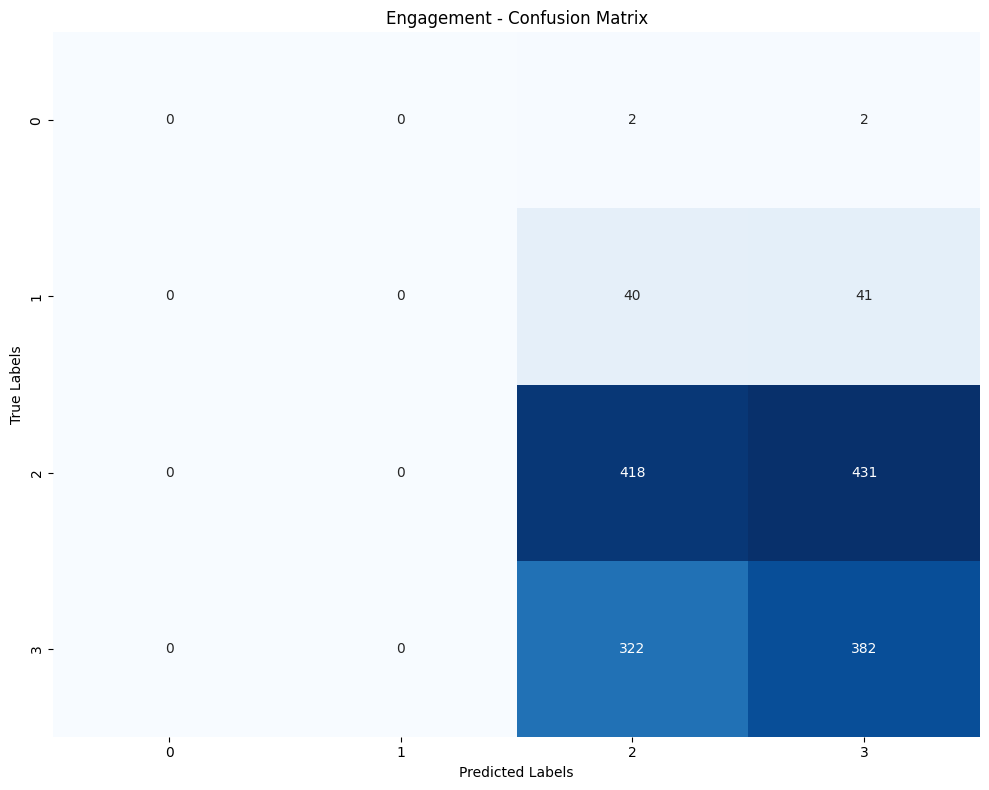

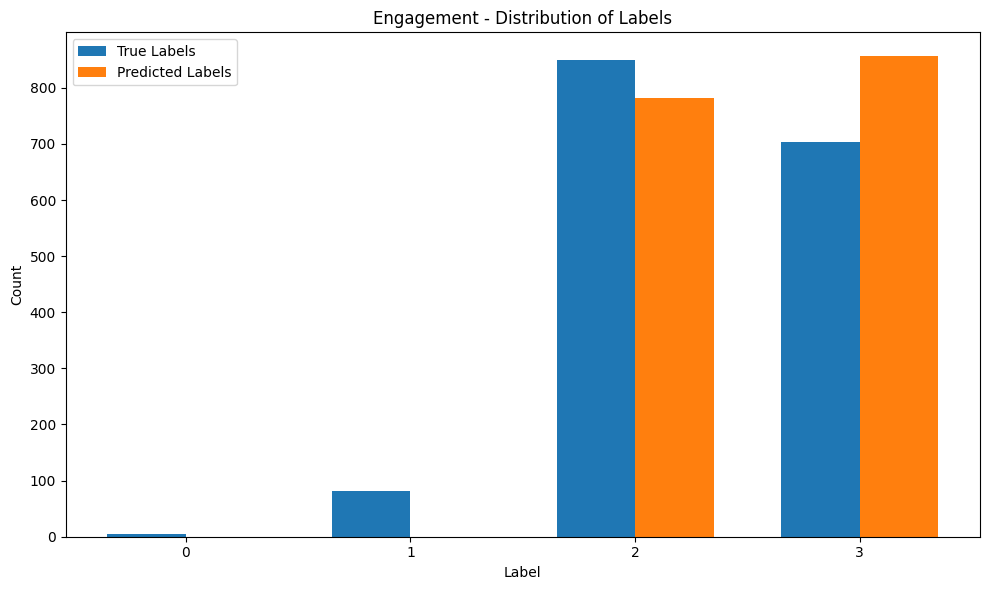

Classification report for Boredom:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       747
           1       0.30      0.30      0.30       519
           2       0.20      0.20      0.20       335
           3       0.03      0.03      0.03        37

    accuracy                           0.33      1638
   macro avg       0.24      0.24      0.24      1638
weighted avg       0.33      0.33      0.33      1638

Confusion Matrix:
[[322 256 157  12]
 [249 157 102  11]
 [163  98  66   8]
 [ 16  13   7   1]]


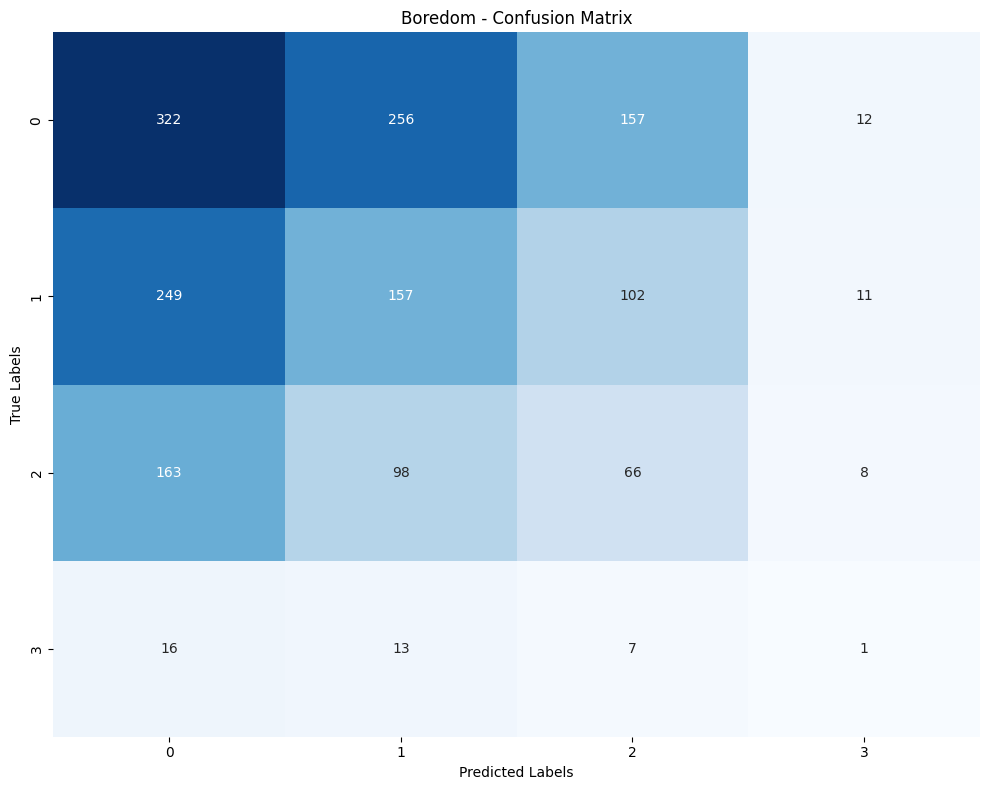

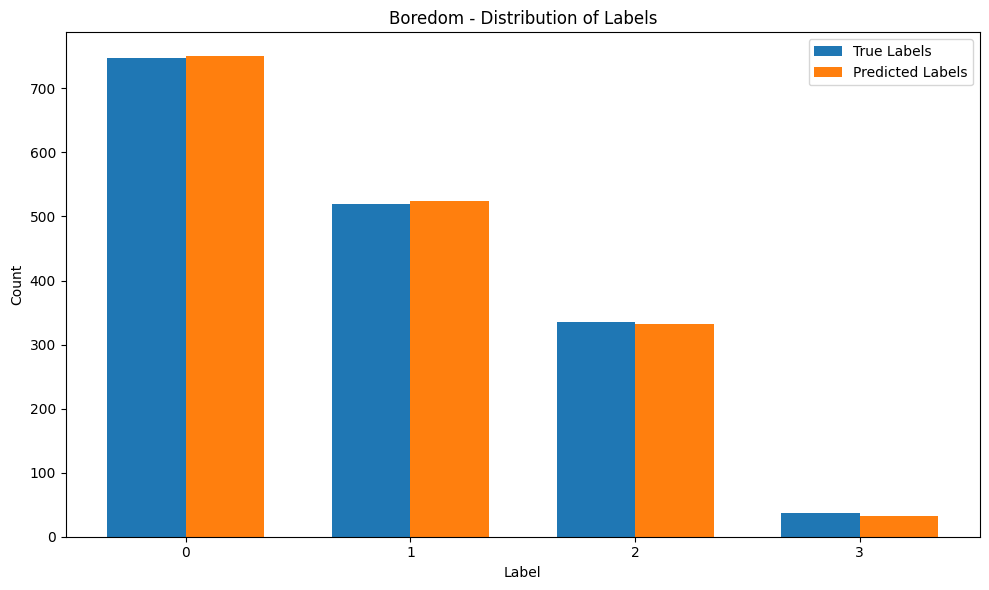

Classification report for Confusion:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1135
           1       0.27      0.27      0.27       368
           2       0.04      0.03      0.04       116
           3       0.00      0.00      0.00        19

    accuracy                           0.56      1638
   macro avg       0.25      0.25      0.25      1638
weighted avg       0.55      0.56      0.55      1638

Confusion Matrix:
[[814 234  74  13]
 [248  98  20   2]
 [ 86  25   4   1]
 [ 16   3   0   0]]


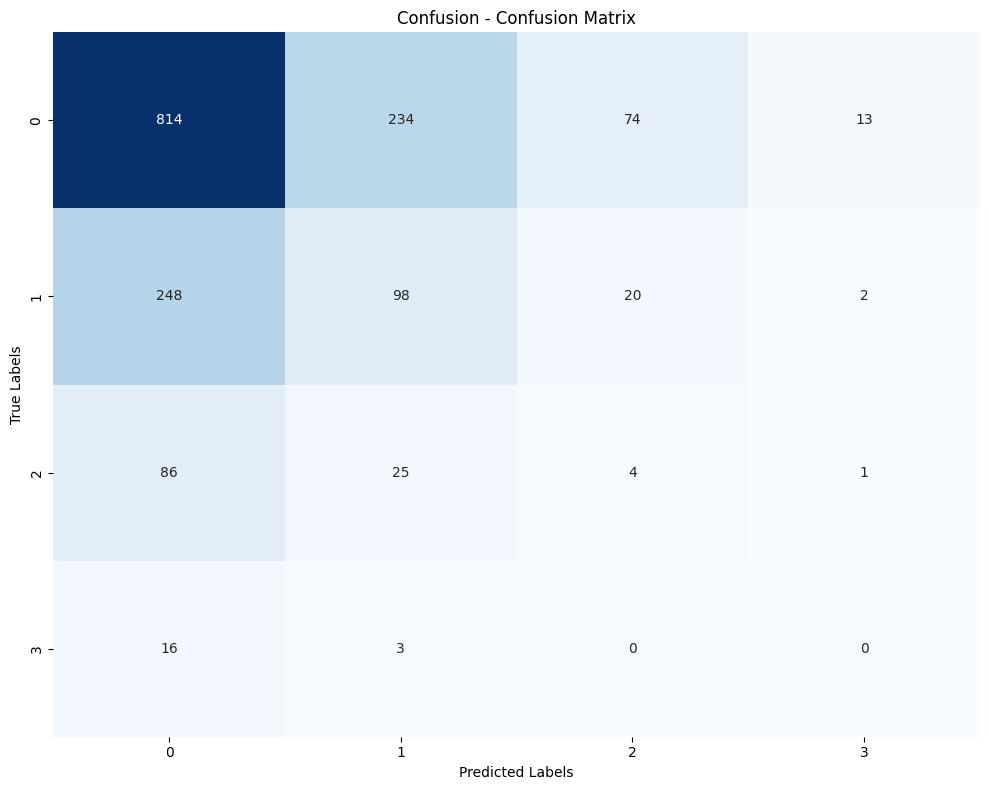

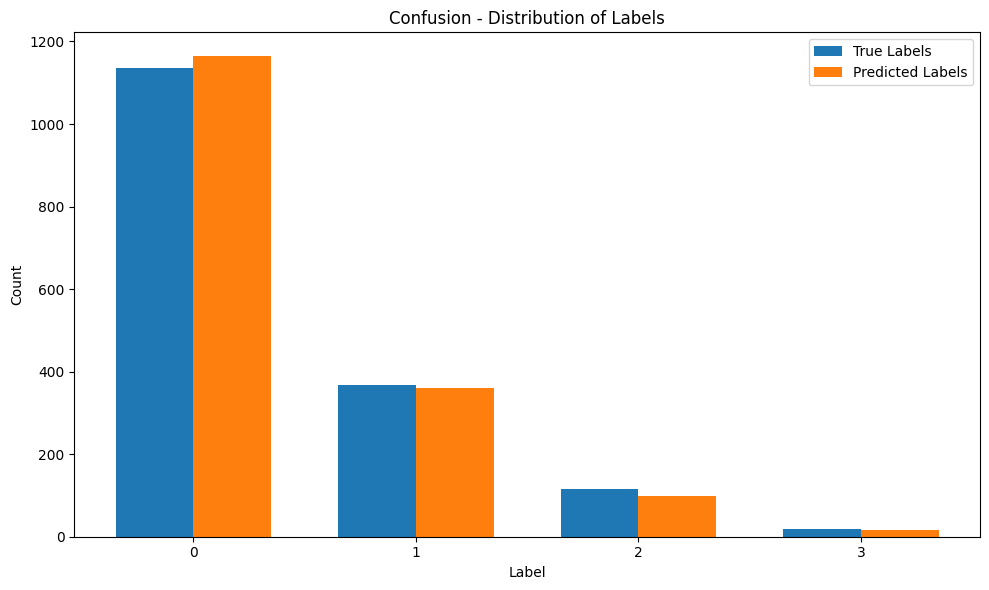

Classification report for Frustration:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1279
           1       0.21      0.16      0.18       280
           2       0.02      0.02      0.02        56
           3       0.00      0.00      0.00        23

    accuracy                           0.68      1638
   macro avg       0.25      0.25      0.25      1638
weighted avg       0.65      0.68      0.66      1638

Confusion Matrix:
[[1066  159   43   11]
 [ 226   45    5    4]
 [  48    6    1    1]
 [  20    3    0    0]]


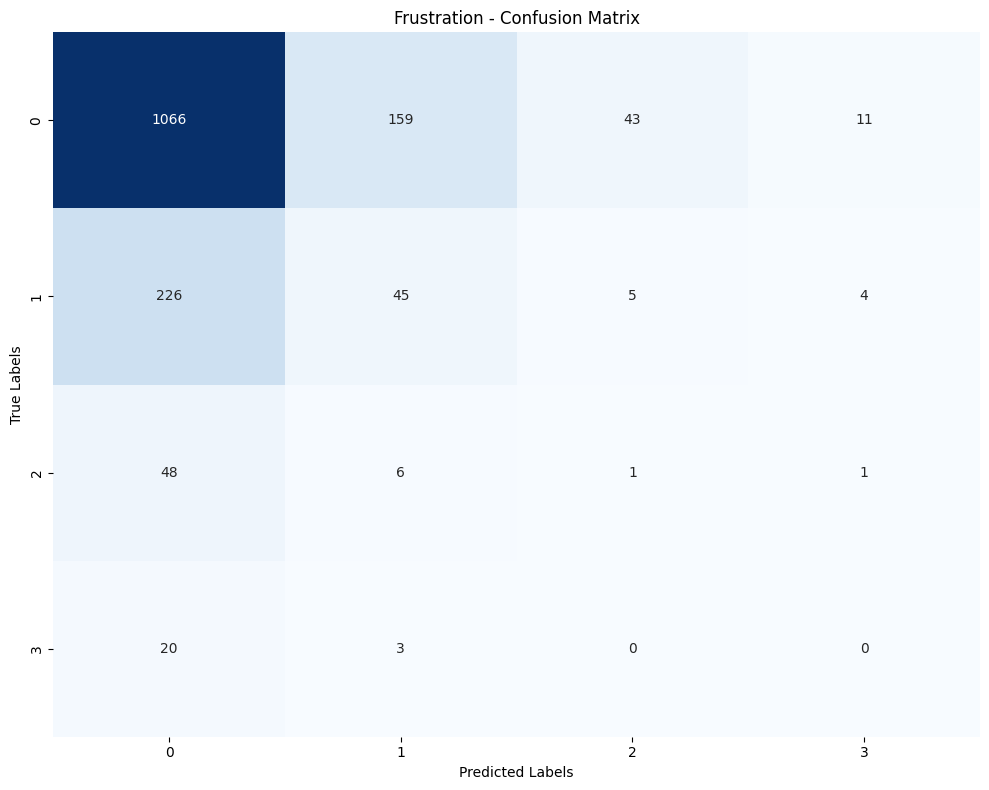

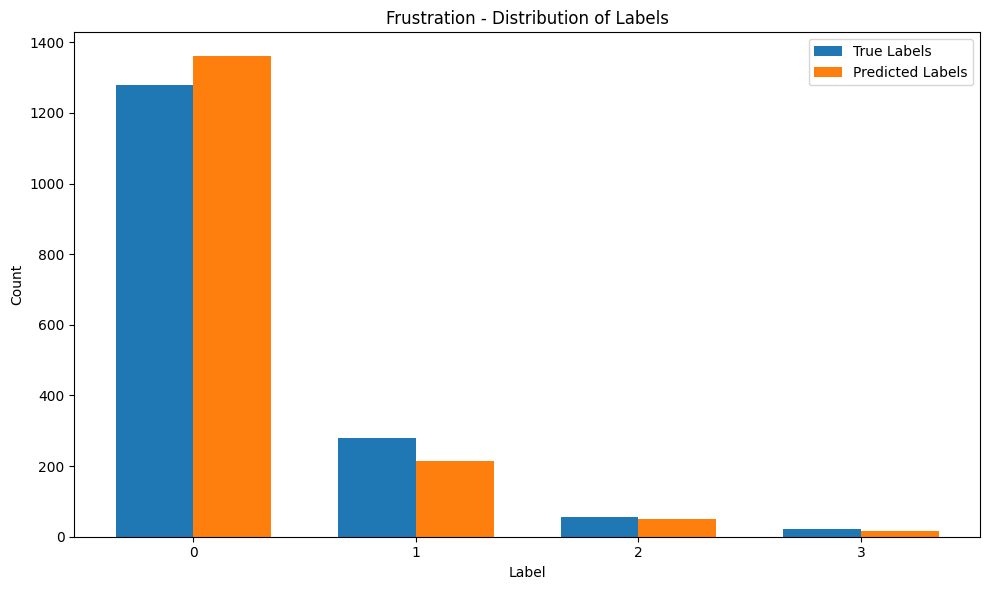


--- Evaluation Complete ---


In [4]:
if __name__ == "__main__":
    # Clean slate - prevent multiprocessing issues
    for pid in [p.pid for p in torch.multiprocessing.active_children()]:
        try:
            os.kill(pid, 0)  # Check if process exists
            print(f"Found stale process with PID {pid}")
        except OSError:
            pass  # Process no longer exists
            
    # Force new process start method
    try:
        torch.multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass  # Already set
    
    
    # CSV file paths
    train_csv = LABELS_DIR / "TrainLabels.csv"
    val_csv = LABELS_DIR / "ValidationLabels.csv"
    test_csv = LABELS_DIR / "TestLabels.csv"
    
    # Precompute caches and LMDB for each resolution
    resolutions = [112, 168, 224, 300]
    for csv in [train_csv, val_csv, test_csv]:
        for res in resolutions:
            precompute_best_frames(csv, FRAMES_DIR, num_frames=NUM_FRAMES, resolution=res)
            convert_pkl_to_lmdb(csv, num_frames=NUM_FRAMES, resolution=res,
                                transform=get_transform(res), lmdb_map_size=1 * 1024**3)
    
    # ------------------------------
    # Hyperparameter Tuning using Progressive Training over All 3 Resolutions
    # ------------------------------
    def objective(trial):
        """Optuna objective function for hyperparameter optimization"""
        # Sample hyperparameters
        batch_size = trial.suggest_categorical("batch_size", [8, 12, 16])
        lr = trial.suggest_float("lr", 5e-5, 2e-4, log=True)
        lstm_hidden = trial.suggest_categorical("lstm_hidden", [384])  # Fixed for stability
        lstm_layers = trial.suggest_categorical("lstm_layers", [2])    # Fixed for stability  
        dropout_rate = trial.suggest_categorical("dropout_rate", [0.2, 0.25, 0.3])
        
        # Create model with the sampled hyperparameters
        model = EfficientNetV2L_RefinedCrossAttn_CBAM(
            lstm_hidden=lstm_hidden,
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate
        ).to(device)
        
        # Architecture-specific checkpoint path
        trial_checkpoint = MODEL_DIR / f"trial_{trial.number}"
        
        # Train the model
        loss = progressive_train_model(
            model,
            15,  # Reduced epochs for trials
            lr,
            trial_checkpoint,
            batch_size,
            patience=3  # Lower patience for faster trials
        )
        
        return loss
    
    db_path = BASE_DIR / "notebooks" / "tuning_eff_v2l_refined_crossattn_cbam.db"
    
    db_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        conn = sqlite3.connect(db_path)
        print(f"Database created/connected at: {db_path}")
        conn.close()
    except Exception as e:
        print(f"DB Error: {e}")

    # Create and run the study
    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
        study_name="efficientnetv2l_refined_crossattn_cbam_study",
        storage=f"sqlite:///{db_path}",
        load_if_exists=True
    )

    # Add this inside your main program after study creation
    try:
        # Run optimization trials
        target_trials = 30
        while True:
            successes = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
            remaining = target_trials - len(successes)
            if remaining <= 0:
                break
            print(f"Running {remaining} additional trial(s) to reach {target_trials} successful trials...")
            study.optimize(objective, n_trials=remaining, catch=(Exception,))
    except KeyboardInterrupt:
        print("Training interrupted by user. Saving current state...")
        # Optional: Save any interim results here
    finally:
        # Display results from trials that were completed
        successes = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
        if successes:
            best_trial = min(successes, key=lambda t: t.value)
            print(f"Best trial parameters from completed trials: {best_trial.params}")
        else:
            print("No successful trials completed.")
   
# ------------------------------
# Final Training with Best Parameters
# ------------------------------
    total_epochs = sum(eps for _, eps in PROG_SCHEDULE)
    arch_suffix = f"_h{best_trial.params.get('lstm_hidden', 384)}_l{best_trial.params.get('lstm_layers', 2)}_d{int(best_trial.params.get('dropout_rate', 0.25)*100)}"
    final_checkpoint = MODEL_DIR / f"final_model_eff_v2l_refined_crossattn_cbam{arch_suffix}.pth"
    
    # Check for the file with duplicated suffix instead
    duplicated_suffix = f"{arch_suffix}{arch_suffix}"
    actual_checkpoint_path = MODEL_DIR / f"final_model_eff_v2l_refined_crossattn_cbam{duplicated_suffix}.pth"

    if not actual_checkpoint_path.exists():
        print("\n--- Starting Final Training ---")
        
        # Best params based on typical strong configurations
        batch_size = 8
        lr = 1e-4  # Higher LR for better optimization
        lstm_hidden = 384  # Larger hidden size
        lstm_layers = 2    # Use 2 layers
        dropout_rate = 0.25  # Lower dropout
        
        # Try to load best trial parameters if available
        if 'best_trial' in locals() and hasattr(best_trial, 'params'):
            params = best_trial.params
            batch_size = params.get("batch_size", batch_size)
            lr = params.get("lr", lr)
            lstm_hidden = params.get("lstm_hidden", lstm_hidden)
            lstm_layers = params.get("lstm_layers", lstm_layers)
            dropout_rate = params.get("dropout_rate", dropout_rate)
        
        final_model = EfficientNetV2L_RefinedCrossAttn_CBAM(
            lstm_hidden=lstm_hidden,
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate,
            classifier_hidden=256
        ).to(device)
        
        # Train for longer with extended patience
        final_loss = progressive_train_model(
            final_model,
            total_epochs,
            lr,
            final_checkpoint,
            batch_size,
            patience=7,  # Increased patience
            gradient_accum_steps=GRADIENT_ACCUM_STEPS
        )
        
        print(f"Final training complete with loss: {final_loss:.4f}")
        save_checkpoint(final_model, None, total_epochs, final_loss, final_checkpoint)
        print(f"Final model explicitly saved to: {final_checkpoint}")
    else:
        print("\n--- Skipping Final Training (Checkpoint Exists) ---")
        print(f"Using existing model from: {actual_checkpoint_path}")
        # Define batch_size here too for evaluation
        batch_size = best_trial.params.get("batch_size", 8)
        lstm_hidden = best_trial.params.get("lstm_hidden", 384)
        lstm_layers = best_trial.params.get("lstm_layers", 2)
        dropout_rate = best_trial.params.get("dropout_rate", 0.25)
    
    # ------------------------------
    # Evaluation on Test Set using Highest Resolution (300x300)
    # ------------------------------
    test_transform = get_transform(300)
    test_set = VideoDatasetRaw(test_csv, FRAMES_DIR, num_frames=NUM_FRAMES, transform=test_transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    eval_model = EfficientNetV2L_RefinedCrossAttn_CBAM(
        lstm_hidden=best_trial.params.get("lstm_hidden", 384),
        lstm_layers=best_trial.params.get("lstm_layers", 2),
        dropout_rate=best_trial.params.get("dropout_rate", 0.25),
        classifier_hidden=256
    ).to(device)
    
    duplicated_suffix = f"{arch_suffix}{arch_suffix}"
    actual_checkpoint = MODEL_DIR / f"final_model_eff_v2l_refined_crossattn_cbam{duplicated_suffix}.pth"
    print(f"Looking for checkpoint at: {actual_checkpoint}")
    load_success = load_checkpoint(eval_model, None, actual_checkpoint)
    if not load_success:
        print("Error: Failed to load checkpoint with architecture compatibility!")
        sys.exit(1)
        
    eval_model.to(device)
    evaluate_model(eval_model, test_loader)
    torch.cuda.empty_cache()
    gc.collect()
    print("\n--- Evaluation Complete ---")